In [ ]:
#CHECKPOINT 0: Create GCP instance w/ GPU and nice CPUs, fork test-gcp-transfer. 

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# !wget -o 20kGauss.npy "https://firebasestorage.googleapis.com/v0/b/test-51594.appspot.com/o/20kGauss.npy?alt=media&token=0268f477-b210-4745-b419-2ba5ea966f4e "

In [ ]:
# !wget -o EyeRGBMap.mat "https://firebasestorage.googleapis.com/v0/b/hseye-fff80.appspot.com/o/EyeRGB.mat?alt=media&token=9e6f4cd8-c48d-4de2-a078-05f6c1604743"

In [3]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.io
import numpy as np
from DataGenerator import DataGenerator
from TrainingManager import TrainingManager
from VideoGenerator import VideoGenerator
from Losses import Losses
import torch
import cv2
from IPython.display import clear_output
from IPython.display import display
from IPython.display import Video
import imageio
import os
import time
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.video.VideoClip import VideoClip
import moviepy.editor as mpy
from IPython.display import Image


In [16]:
# vGenerator = VideoGenerator(topNm = 2000,  frameRate = 1, blinkDuration = 1)

In [55]:
iGenerator = DataGenerator(topNm = 2000)

In [56]:
# vImages, _, vMaps = vGenerator.generateVideos(10)
images, maps = iGenerator.generatePerlinData(10)

100%|██████████| 10/10 [00:00<00:00, 18.49it/s]


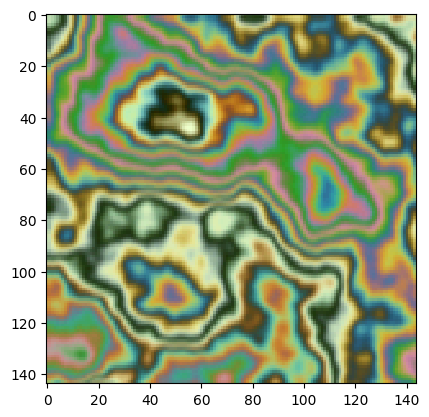

In [67]:
showImage(images[0])

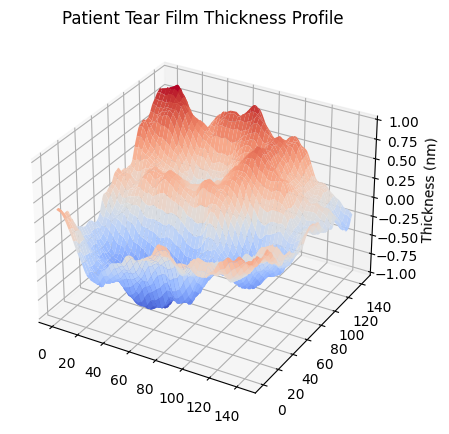

In [66]:
showMap(maps[0])

In [7]:
def make_images(images):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # codec for mp4 video
    video = cv2.VideoWriter("video.mp4", fourcc, 2.0, (144, 144))

    for i in range(12):
        video.write(images[i])
    
    video.release()

    return Video("video.mp4")

def imRegulate(data):
    m = np.max(data)
    mi = np.min(data)
    norm = ((data - mi) / (m - mi))*255
    return norm.astype(np.uint8)

def show_images(images, index):
    localFlush()
    make_images(imRegulate(images[0]))
    mp4_to_gif("video.mp4", "output.gif")
    return Image(filename='output.gif')

def mp4_to_gif(input_path, output_path):    
    # Read the mp4 file using imageio
    reader = imageio.get_reader(input_path)

    # Create a list to store all frames of the video
    frames = []
    for i, frame in enumerate(reader):
        frames.append(frame)

    # Write the frames to a gif using imageio
    writer = imageio.get_writer(output_path, mode='I', fps=reader.get_meta_data()['fps'])
    for frame in frames:
        writer.append_data(frame)
    writer.close()

def localFlush():
    if os.path.exists("video.mp4"):
        os.remove("video.mp4")
    else:
        pass

    if os.path.exists("output.gif"):
        os.remove("output.gif")
    else:
        pass
    

In [10]:


plt.ioff() # turn off interactive mode

def plot_3d(x, y, z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_zlim(-1, 1)
    ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    return mplfig_to_npimage(fig)

def create_map(frame_idx, data):
    x, y = np.meshgrid(np.linspace(0, 144, 144), np.linspace(0, 144, 144))
    z = data[frame_idx]
    return plot_3d(x, y, z, f"Frame {frame_idx}")

def create_map_video(data, filename):
    n_frames = data.shape[0]
    video = VideoClip(lambda t: create_map(int(t * n_frames), data), duration=n_frames / 30)
    video.write_videofile(filename, fps=5, verbose=False, logger=None)
    
def show_maps(data, index):
    create_map_video(data[index], "maps.mp4")
    mp4_to_gif("maps.mp4", "maps.gif")
    return Image(filename='maps.gif')


In [11]:
def auxSlice(content, channels):
    numVid = content.shape[0]
    numFrame = content.shape[1]
    width = content.shape[2]
    height = content.shape[3]
    
    
    slices = np.zeros((numVid, numFrame*width, height, channels))
        
    for i in range(numVid):
        stack = []
        for k in range(numFrame):
            stack.append(content[i][k].reshape(width, height, channels))
        slices[i] = np.vstack(stack)
        
        
    return slices

        

In [9]:
from matplotlib import pyplot as plt
import heapq
import csv
from matplotlib import cm

def showImage(image):
    data = np.reshape(image, (image.shape[0],image.shape[1],3))
    plt.imshow(imRegulate(data), interpolation='nearest')
    return plt.show()
    
    
def showMap(depthMap):

    d1 = depthMap.shape[0]
    d2 = depthMap.shape[1]
    
    pData = np.reshape(depthMap, (d1,d2))

    fig = plt.figure(figsize = (5,5))
    ax1 = fig.add_subplot(projection='3d')

    x = np.arange(0, d1)
    y = np.arange(0, d2)
    
    X, Y = np.meshgrid(x, y)
    surf = ax1.plot_surface(X, Y, pData, cmap = cm.coolwarm)

    ax1.set_zlabel("Thickness" + " (" + "nm" + ")")
    ax1.set_title('Patient Tear Film Thickness Profile')



    return plt.show()
    
        



def tRegulate(data):
    data = tf.truediv(
       tf.subtract(
          data, 
          tf.reduce_min(data)
       ), 
       tf.subtract(
          tf.reduce_max(data), 
          tf.reduce_min(data)
       )
    )
    return tf.math.multiply(data,5000)

@tf.custom_gradient
def tCycle(depth):
    depth = tRegulate(depth)
    depth = tf.convert_to_tensor(depth)
    depth = tf.cast(tf.reshape(depth, (48*48)), tf.int32).numpy()
    print(depth)

    def grad(upstream):
            values = dColorMap[[depth]]
            ret = tf.convert_to_tensor(values.reshape(1,48,48,3).astype(np.float32))
            return ret * upstream
    
    values = colorMap[[depth]]
    return tf.convert_to_tensor(values.reshape(1,48,48,3).astype(np.float32)), grad


In [15]:
# convert the numpy arrays to tensors
images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(maps, dtype=tf.float32)

# create a dataset from the tensors
dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))


2023-02-05 19:35:12.110447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 19:35:12.162087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 19:35:12.163906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 19:35:12.166978: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
losses = Losses()

In [12]:
from Database import Database
database = Database() #CHECKPOINT 1: Compile to this point.

Instance already initialized


In [13]:
noisyRGB = {
    "gen_down" : [512,1024,2048],
    "gen_up": [512,1024,2048],
    "gen_dropout" : [True, False, False],
    "disc_down": [32],
    "gen_lr": 0.0002,
    "gen_b1": 0.5,
    "disc_lr" : 0.0002,
    "disc_b1": 0.5,
    "epochs": 50,
    "time": database.fetchDate(),
    "name" : "overfit10/",
    "topNm": 2000,
    "d1": 144,
    "d2": 144
}

In [ ]:
vidRGB = {
    "gen_down" : [128,256,512],
    "gen_up": [128,256,512],
    "gen_dropout" : [True, True, False],
    "disc_down": [32],
    "gen_lr": 0.0002,
    "gen_b1": 0.5,
    "disc_lr" : 0.0002,
    "disc_b1": 0.5,
    "epochs": 6,
    "time": database.fetchDate(),
    "name" : "longtest1",
    "topNm": 5000,
    "notes": "Noisy, 0.1",
    "optimalCheckpoint": 10,
    "numVid": 10, 
    "d1": 1728, 
    "d2": 144
}

In [16]:
noisyRGBManager = TrainingManager(noisyRGB, images, maps, images , maps)

In [ ]:
# noisyRGBManager = TrainingManager(noisyRGB, auxSlice(images, 3), auxSlice(maps, 1), auxSlice(images, 3) ,auxSlice(maps, 1))

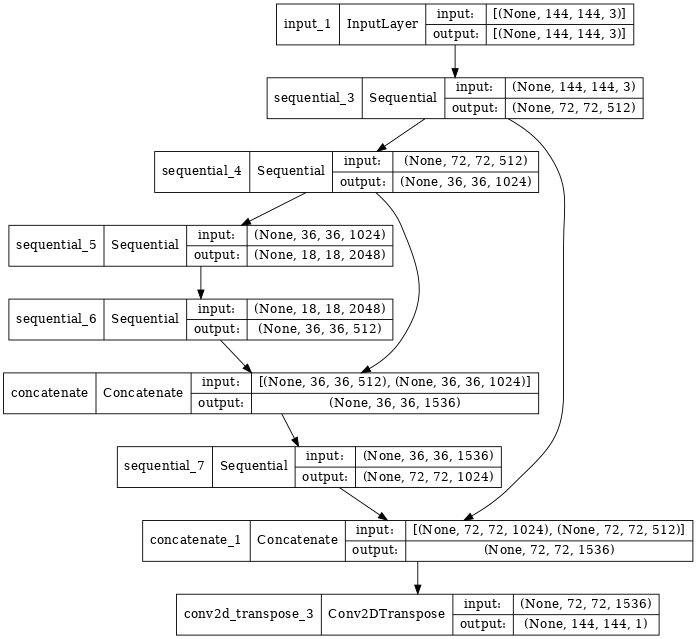

In [17]:
noisyRGBManager.previewGenerator()

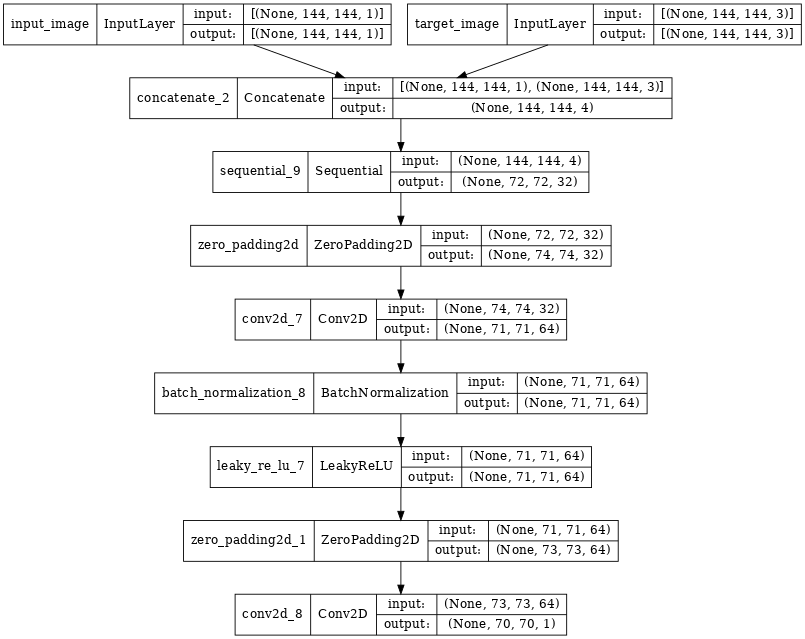

In [18]:
noisyRGBManager.previewDiscriminator()

In [ ]:
noisyRGBManager.fit() #CHECKPOINT 2: Finish a training session. 

2023-02-05 19:35:44.201692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
#ERROR: WARNING:tensorflow:Model was constructed with shape (None, 144, 144, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 144, 144, 1), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'"), but it was called on an input with incompatible shape (1, 144, 144, 3).



In [6]:
#CHECKPOINT 3: Create some testing infrastructure. --> Run some testing videos, get output, and display output. (One at a time for now)